Preprocessing and Training Splits
---

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.regressionplots import *
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
total_set = pd.read_json('../data/interim/Step 2 - Total Set.json', orient='records', convert_axes=False)
train_set = pd.read_json('../data/interim/Step 2 - Train Set.json', orient='records', convert_axes=False)
test_set = pd.read_json('../data/interim/Step 2 - Test Set.json', orient='records', convert_axes=False)

Just now realized we've been accumulating a extra index columns. Let's drop them. We can re-engineer the "Id" column later by adding 1 to each index value.

In [3]:
total_set.drop(['index', 'Id'], axis=1, inplace=True)
train_set.drop(['index', 'Id'], axis=1, inplace=True)
test_set.drop(['index', 'Id'], axis=1, inplace=True)

In [4]:
# This quickfix will be implemented in upstream notebooks when finalizing the project.

total_set['LandSlope'].replace({5:'Mod', 2:'Sev'}, inplace=True)
train_set = total_set[total_set['set'] == 'train']
test_set = total_set[total_set['set'] == 'test']

Step 1: Clean & One-Hot Categorical Variables
---

Since we converted all ordinal categorical features into numerical features in the previous step, we can skip straight to one-hotting the remaining ones.

BUT! "Condition1"/"Condition2" and "Exterior1st"/"Exterior2nd" are weird. They're pairs of columns that allow for more than one value to be recorded for the given category. So they require an extra step - after they're one-hotted, we should combine their columns in pairs such that every feature that is present will be represented without duplication.

In [5]:
o_cols = total_set.select_dtypes(include=['object'])
o_cols.columns

Index(['MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'set'],
      dtype='object')

In [6]:
o_cols.isnull().sum()

MSZoning            0
Street              0
Alley            2721
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
Foundation          0
Heating             0
Electrical          1
GarageType        157
Fence            2348
MiscFeature      2814
SaleType            1
SaleCondition       0
set                 0
dtype: int64

Oh no! Nulls. Let's deal with them, then, I *guess*...

...but if the missing values occur in our test set, we can't mess with them unless we do so under predefined rules that can be applied to any future data sets with equal effectiveness (and obviously we can't drop them). So let's just look at our training set for now.

In [7]:
o_cols[o_cols['set']=='train'].isnull().sum()

MSZoning            0
Street              0
Alley            1369
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
Foundation          0
Heating             0
Electrical          1
GarageType         81
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
set                 0
dtype: int64

Looks like a LOT of the missing values were in the test set only. So let's just make up rules for any future set we get. The rules should be specific to each column and applicable to any future test set.

I went through the value counts for each column to arrive at these, but that's boring and takes up a lot of notebook space, so I omitted that here.

Let's draft this as a function so that we can reapply it uniformly to any new records.

First, we'll create the dictionary used for any future sets, and then 'store' it for future use.

In [8]:
cat_fillna_dict = {
    'Neighborhood':'Other',
    'Exterior1st':'Other',
    'Exterior2nd':'Other',
    'Foundation':'Other',
    'Alley':'NA',
    'GarageType':'NA',
    'Fence':'NA',
    'MiscFeature':'NA',
    'Condition1':'Norm',
    'Condition2':'Norm',
}

to_mode = ['LandContour', 'Street', 'MSZoning', 'Utilities', 'LotConfig', \
           'LandSlope', 'BldgType', 'HouseStyle', 'RoofMatl', 'MasVnrType', \
            'Heating', 'Electrical', 'SaleType', 'SaleCondition']

# Be sure to get the mode of the TRAINING set, to avoid bleed.
for col in to_mode :
    cat_fillna_dict[col] = train_set[col].mode()[0]

%store cat_fillna_dict

Stored 'cat_fillna_dict' (dict)


In [9]:
def cat_fillna(df) :
    """Fills NA values of non-ordinal categorical features for this data set.
    
    df is a dataframe (presumably a new test set) which must have the same columns as the original set these notebooks are based on.

    Uses the %stored dictionary 'cat_fillna_dict' to determine the .fillna() values.

    """
    
    %store -r cat_fillna_dict

    for col in cat_fillna_dict :
        df[col].fillna(value=cat_fillna_dict[col], inplace=True)
    return df

In [10]:
total_set = cat_fillna(total_set)

In [11]:
o_cols = total_set.select_dtypes(include=['object'])
o_cols.isnull().sum()

MSZoning         0
Street           0
Alley            0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
Foundation       0
Heating          0
Electrical       0
GarageType       0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
set              0
dtype: int64

Before we proceed, I want to see which of these categorical features might have strong correlations to the label.

In [12]:
train_set = total_set[total_set['set']=='train']
cat_vars = list(o_cols.columns)
cat_vars.remove('set')

anovas = pd.DataFrame()

for col in cat_vars :
    anova = pg.welch_anova(data=train_set, dv='SalePrice', between=col)
    anovas = pd.concat([anovas, anova], axis=0)

anovas = anovas.sort_values(by='np2', ascending=False, ignore_index=True)
anovas

,Source,ddof1,ddof2,F,p-unc,np2
0,Neighborhood,24,120.906806,56.151276,3.019500e-54,0.545575
1,Foundation,5,15.703022,83.388974,9.681547e-11,0.256368
2,GarageType,6,41.123361,114.822461,4.477164e-24,0.249204
3,MasVnrType,3,64.900991,78.705972,1.376994e-21,0.183277
4,Exterior2nd,15,70.632115,16.175842,3.362159e-17,0.153830
5,Exterior1st,14,35.144731,22.018127,2.603830e-13,0.152773
6,SaleType,8,10.815942,13.434211,1.259831e-04,0.137287
7,SaleCondition,5,24.521524,28.339072,1.933879e-09,0.135497
8,MSZoning,4,43.892971,95.072489,4.951041e-21,0.107560
9,HouseStyle,7,61.211487,41.792095,5.449573e-21,0.086313


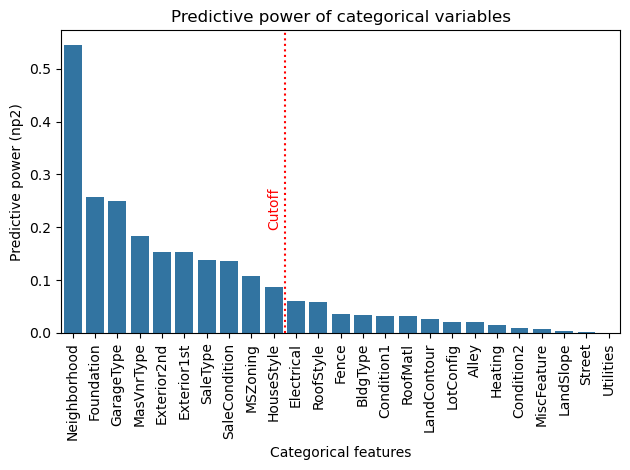

In [13]:
# plt.figure(figsize=(10, 7))


sns.barplot(data=anovas, x='Source', y='np2')
plt.xticks(rotation=90)
plt.axvline(9.5, color="Red", linestyle=":")
plt.annotate("Cutoff", xy=(8.7, 0.2), rotation=90, color="Red")
plt.xlabel("Categorical features")
plt.ylabel("Predictive power (np2)")
plt.title("Predictive power of categorical variables")
plt.tight_layout()
plt.savefig("../reports/figures/Cat_Var_Predictive_Power")
plt.show()

Let's arbitrarily select the 10 most influential variables (by np2), as they all also have significant p values.

In [14]:
usable_cats = list(anovas.loc[:9, 'Source'])

%store usable_cats

Stored 'usable_cats' (list)


Now we're ready to one-hot!

In [15]:
for col in usable_cats :
    oh = pd.get_dummies(total_set[col], prefix=col).astype(int)
    total_set = total_set.join(oh, on=None)

total_set = total_set.drop(cat_vars, axis=1)

And now let's fix the Exterior column pairs (since we've dropped the Condition 1&2 columns).

In [16]:
# First let's get all our relevant columns.
# We only need the second of each pair, since we can use that to derive the first of each pair.
exterior2_cols = []

for col in total_set.columns :
    if "Exterior2" in col :
        exterior2_cols.append(col)


In [17]:
# Now let's find all the 1s in the second column and copy them to the first of the pairs, then drop the second of the pairs.
# It's kind of annoying, but we can manually change the 2 to a 1 in the col name string.

# And the same for Exterior:
for index, row in total_set.iterrows() :
    for col in exterior2_cols :
        if total_set.loc[index, col] == 1 :
            new_col = col[:8]+'1st'+col[11:]
            total_set.loc[index, new_col] = 1

# And presto.
total_set.drop(exterior2_cols, axis=1, inplace=True)

I just noticed that there are discrepancies in one of the value names:

Exterior1st_WdShing

vs

Exterior1st_Wd Shng 

Let's go through a similar process as before to move all the values from the second version into the first version, then remove the second version's column.


In [18]:
for index, row in total_set.iterrows() :
    if total_set.loc[index, 'Exterior1st_Wd Shng'] == 1 :
        total_set.loc[index, 'Exterior1st_WdShing'] = 1

total_set = total_set.drop('Exterior1st_Wd Shng', axis=1)

I just noted that one of the values in the BldgType column is out of step with the documentation.

'twnhs' isn't in the documentation, and should apparently be either 'TwhsE' or 'TwnhsI', but we have no way of seeing which.

Let's see if it even matters...

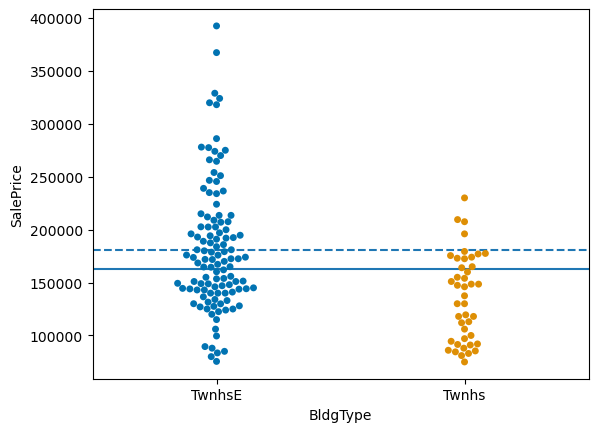

In [19]:
small_df = train_set[(train_set['BldgType']=='TwnhsE') | (train_set['BldgType']=='Twnhs')]

sns.swarmplot(x='BldgType', y='SalePrice', data=small_df, palette='colorblind')
plt.axhline(train_set['SalePrice'].mean(), linestyle='--')
plt.axhline(train_set['SalePrice'].median())
plt.show()


Kinda seems like it does...

In [20]:
from scipy.stats import ks_2samp

In [21]:
TwnhsE = train_set[train_set['BldgType']=='TwnhsE']['SalePrice']
Twnhs = train_set[train_set['BldgType']=='Twnhs']['SalePrice']
stat, p_val = ks_2samp(TwnhsE, Twnhs)
print("P-value between TwnhsE and Twnhs sale price distributions: "+str(round(p_val, 6)))

P-value between TwnhsE and Twnhs sale price distributions: 0.000346


Yeah, probably does. Let's make the BOLD assumption that Twnhs is supposed to be TwnhsI, and convert all future Twnhs values to TwnhsI, in keeping with the documentation.

In [22]:
def townhouse(df) :
    df.replace({'Twnhs':"TwnhsI"}, inplace=True)
    return df

In [23]:
train_set = townhouse(train_set)
test_set = townhouse(test_set)
train_set['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
TwnhsI      43
2fmCon      31
Name: BldgType, dtype: int64

And let's backfill that for our already one-hotted df.

In [24]:
total_set.rename(columns={"BldgType_Twnhs":"BldgType_TwnhsI"}, inplace=True)

Step 2: Preparing the Numeric Columns
--

Let's make sure we don't have any nulls left over from last time.

In [25]:
n_cols = [name for name in total_set.columns if "_" not in name]
n_cols.remove('SalePrice')

n_df = total_set[n_cols]
n_df

,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,set
0,60,65.0,8450,4,7,5,2003,2003,196.0,4,...,61,0,0,0,0,NaN,0,2,2008,train
1,20,80.0,9600,4,6,8,1976,1976,0.0,3,...,0,0,0,0,0,NaN,0,5,2007,train
2,60,68.0,11250,3,7,5,2001,2002,162.0,4,...,42,0,0,0,0,NaN,0,9,2008,train
3,70,60.0,9550,3,7,5,1915,1970,0.0,3,...,35,272,0,0,0,NaN,0,2,2006,train
4,60,84.0,14260,3,8,5,2000,2000,350.0,4,...,84,0,0,0,0,NaN,0,12,2008,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,4,7,1970,1970,0.0,3,...,0,0,0,0,0,NaN,0,6,2006,test
2915,160,21.0,1894,4,4,5,1970,1970,0.0,3,...,24,0,0,0,0,NaN,0,4,2006,test
2916,20,160.0,20000,4,5,7,1960,1996,0.0,3,...,0,0,0,0,0,NaN,0,9,2006,test
2917,85,62.0,10441,4,5,5,1992,1992,0.0,3,...,32,0,0,0,0,NaN,700,7,2006,test


In [26]:
n_df.isnull().sum()

MSSubClass          0
LotFrontage         0
LotArea             0
LotShape            0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
ExterQual           0
ExterCond           0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
HeatingQC           0
CentralAir          0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
Functional          0
Fireplaces          0
FireplaceQu      1420
GarageFinish      159
GarageArea          1
GarageQual        159
GarageCond        159
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea  

I guess we have to go through and define imputation methods for each of them now.

I've checked the documentation & all value counts, but am only leaving one example in the notebook.

4.0    3
5.0    2
2.0    2
Name: PoolQC, dtype: int64


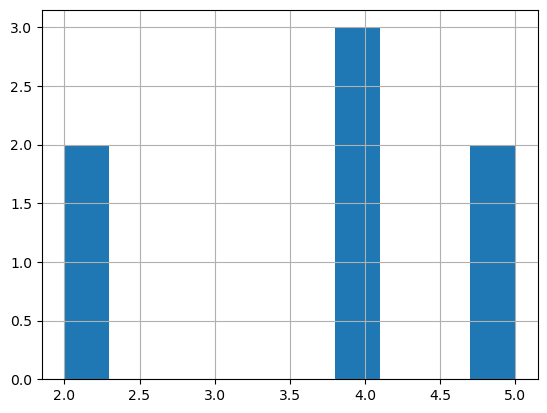

In [27]:
x = 'PoolQC'
print(n_df[n_df['set'] == 'train'][x].value_counts())
n_df[n_df['set'] == 'train'][x].hist()
plt.show()

The following are my decisions RE how to impute the values for each column.

In [28]:
median = ['LotArea', 'OverallQual', 'GrLivArea', 'MSSubClass']
mode = ['LotFrontage', 'LotShape', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', \
        'ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir', 'FullBath', 'BedroomAbvGr', \
        'KitchenAbvGr', 'KitchenQual', 'Functional', 'GarageFinish', 'PavedDrive', ]
zero = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', \
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', \
        'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'GarageArea', 'GarageQual', \
        'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
        'PoolArea', 'PoolQC']

Now let's IMPUUUUTE

In [29]:
for col in median :
    med = total_set[total_set['set'] == 'train'][col].median()
    total_set[col].fillna(med, inplace=True)
for col in mode :
    mod = total_set[total_set['set'] == 'train'][col].mode().iloc[0]
    total_set[col].fillna(mod, inplace=True)
for col in zero :
    total_set[col].fillna(0, inplace=True)

Check for any remaining nulls...

In [30]:
for col in total_set.columns :
    nulls = total_set[col].isnull().sum()
    if nulls > 0 :
        print(col, nulls)

SalePrice 1459
Exterior1st_CmentBd 2793
Exterior1st_Brk Cmn 2897


Really no idea how those two one-hot cols ended up with nulls, but fortunately the only prescription is more cowbell.

In [31]:
print(total_set['Exterior1st_CmentBd'].value_counts())
print(total_set['Exterior1st_Brk Cmn'].value_counts())

1.0    126
Name: Exterior1st_CmentBd, dtype: int64
1.0    22
Name: Exterior1st_Brk Cmn, dtype: int64


In [32]:
total_set['Exterior1st_CmentBd'].fillna(0.0, inplace=True)
total_set['Exterior1st_Brk Cmn'].fillna(0.0, inplace=True)

NOW we're cooking with grease.

One more thing to do before scaling: prune some outliers.

I tooled around with this in conjunction with the modeling notebook, and the 
figure I arrived at was 3.5 standard deviations was a decent cutoff for outliers.

In [33]:
# Let's deal with outliers before scaling.

numerics_to_screen = n_cols.copy()

not_relevant = ['Functional', 'KitchenAbvGr', 'PavedDrive', 'FireplaceQu', 'BsmtHalfBath', \
                'CentralAir', 'YearBuilt', 'YearRemodAdd', 'OverallCond', 'MSSubClass', 'set', \
                    'LotFrontage', 'GarageQual', 'GarageCond', 'Fireplaces', 'HalfBath', \
                        'BsmtFullBath', 'BsmtFinType2', 'BsmtCond', 'ExterCond', 'LotShape']

for irrelevance in not_relevant :
    numerics_to_screen.remove(irrelevance)

count = 0

for col in numerics_to_screen :
    
    nonzero_std = total_set[(total_set['set']=='train') & (total_set[col]!=0)][col].std()
    nonzero_mean = total_set[(total_set['set']=='train') & (total_set[col]!=0)][col].mean()
    upper_bound = nonzero_mean + 3.5*nonzero_std
    lower_bound = nonzero_mean - 3.5*nonzero_std
    print(f'\n{col}\nMean: {nonzero_mean}, STD: {nonzero_std}\nUpper: {upper_bound}\nlower: {lower_bound}')

    for index, row in total_set[total_set['set']=='train'].iterrows() :
        if (row[col] > upper_bound or row[col] < lower_bound) and row[col]!=0 :
            print(f'{index}: {col}: {total_set.loc[index, col]}')
            total_set.drop(index, axis=0, inplace=True)
            count+=1

print(f'\nTotal Removed Rows: {count}')


LotArea
Mean: 10516.828082191782, STD: 9981.264932379147
Upper: 45451.255345518795
lower: -24417.599181135236
53: LotArea: 50271
249: LotArea: 159000
313: LotArea: 215245
335: LotArea: 164660
384: LotArea: 53107
451: LotArea: 70761
457: LotArea: 53227
661: LotArea: 46589
706: LotArea: 115149
769: LotArea: 53504
848: LotArea: 45600
1298: LotArea: 63887
1396: LotArea: 57200

OverallQual
Mean: 6.093296475466483, STD: 1.3791584861370516
Upper: 10.920351176946163
lower: 1.2662417739868017
375: OverallQual: 1
533: OverallQual: 1

MasVnrArea
Mean: 252.22013651877134, STD: 203.72820255650518
Upper: 965.2688454665395
lower: -460.8285724289967
58: MasVnrArea: 1031.0
70: MasVnrArea: 1115.0
115: MasVnrArea: 1129.0
297: MasVnrArea: 1600.0
691: MasVnrArea: 1170.0
808: MasVnrArea: 1047.0
981: MasVnrArea: 975.0
1169: MasVnrArea: 1378.0

ExterQual
Mean: 3.393180236604036, STD: 0.567733340981048
Upper: 5.380246930037704
lower: 1.406113543170368

BsmtQual
Mean: 3.5738758029978586, STD: 0.677497419283282

And now, to scale.

In [34]:
scaler = StandardScaler()

numerics = n_cols.copy()

numerics.pop(-1)

for col in numerics :
    # Only fit the scaler to the training set.
    scaler.fit(total_set[total_set['set']=='train'][[col]])
    # Use the fit scaler to transform both sets.
    total_set[col] = scaler.transform(total_set[[col]])

Step 3: Train Test Split
--

In [35]:
train_set = total_set[total_set['set']=='train']

train_set.drop(columns=['set'], inplace=True)

X = train_set.drop(columns=['SalePrice'])
y = train_set['SalePrice']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 4: Save and Quit
--

In [37]:
total_set.to_json('../data/Step 3 - Total Set.json', orient='records')
X.to_json('../data/Step 3 - X.json', orient='records')
y.to_json('../data/Step 3 - y.json', orient='records')
X_train.to_json('../data/Step3 - X_train.json', orient='records')
X_test.to_json('../data/Step3 - X_test.json', orient='records')
y_train.to_json('../data/Step3 - y_train.json', orient='records')
y_test.to_json('../data/Step3 - y_test.json', orient='records')